# 274to289 (1-15 Oktober)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Oct1-15woPe deaths.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_leth_AGS_274to289']
X = df.loc[:, ~df.columns.isin(['std_leth_AGS_274to289'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# Feature Correlation

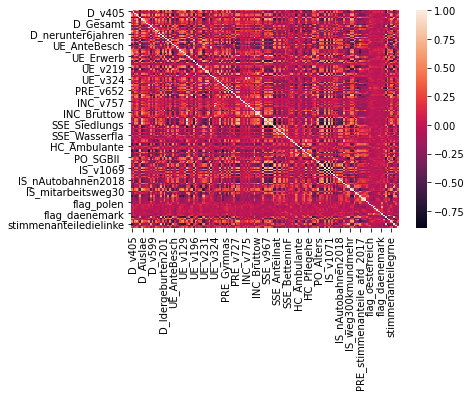

In [4]:
corr = X.corr()
sns.heatmap(corr)

In [5]:
pairs = []

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            pairs.append(corr.columns[[i,j]][0])
            pairs.append(corr.columns[[i,j]][1])
            print(corr.columns[[i,j]],corr.iloc[i,j])
            

Index(['D_Lebens', 'D_v599'], dtype='object') 0.9204456724863153
Index(['D_Lebens', 'HC_Vorzeitig'], dtype='object') -0.853570725481162
Index(['D_nervon6bisunter', 'Keine_religion'], dtype='object') 0.8558915963431473
Index(['D_nervon6bisunter', 'stimmenanteiledielinke'], dtype='object') 0.8337102560504743
Index(['UE_ArbquoteJ', 'PO_SGBII_'], dtype='object') 0.8310490758054104
Index(['UE_AntreBesc', 'UE_AnteBesch'], dtype='object') -0.8073819685836338
Index(['UE_BesePrima', 'UE_v305'], dtype='object') 0.8333318048923829
Index(['UE_Erwerb', 'SSE_Einwohner'], dtype='object') 0.8980642650031009
Index(['UE_Erwerb', 'SSE_v967'], dtype='object') 0.9540188242864167
Index(['UE_Erwerb', 'SSE_Siedlungs'], dtype='object') 0.8849779610806378
Index(['UE_Erwerb', 'SSE_AnteilErh'], dtype='object') 0.8137246324046928
Index(['UE_Erwerb', 'SSE_AnteilFre'], dtype='object') -0.897382514680414
Index(['UE_v190', 'PRE_v727'], dtype='object') 0.9155820449459644
Index(['UE_v202', 'PRE_v733'], dtype='object') 0

In [6]:
len(pairs)
len(set(pairs))

47

In [7]:
#sns.heatmap(X[set(pairs)].corr())

# First CatBoost Model with 155 features

In [8]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9989774687082743


In [9]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.02834112764482901


# SHAP VAlues

In [10]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

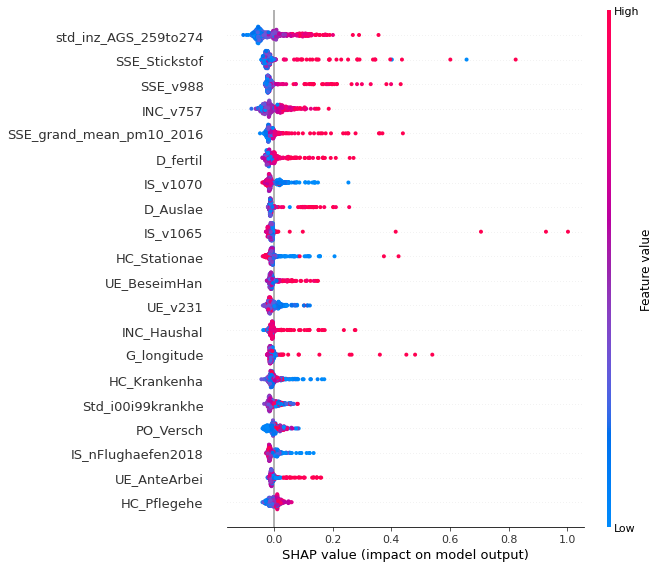

In [11]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [12]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [13]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9966042829051356


In [14]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  0.05164693733627237


# Compare top 10 features of both Models

In [15]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_259to274', 'SSE_Stickstof', 'SSE_v988', 'INC_v757', 'SSE_grand_mean_pm10_2016', 'D_fertil', 'IS_v1070', 'D_Auslae', 'IS_v1065', 'HC_Stationae'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_259to274', 'INC_v757', 'D_fertil', 'SSE_Stickstof', 'SSE_v988', 'SSE_grand_mean_pm10_2016', 'UE_AnteArbei', 'UE_BeseimHan', 'PO_Versch', 'Std_i00i99krankhe']


In [16]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_259to274
SSE_Stickstof
SSE_v988
INC_v757
SSE_grand_mean_pm10_2016
D_fertil


ABS_SHAP(shap_values_cb_20,X[top20feature]) 

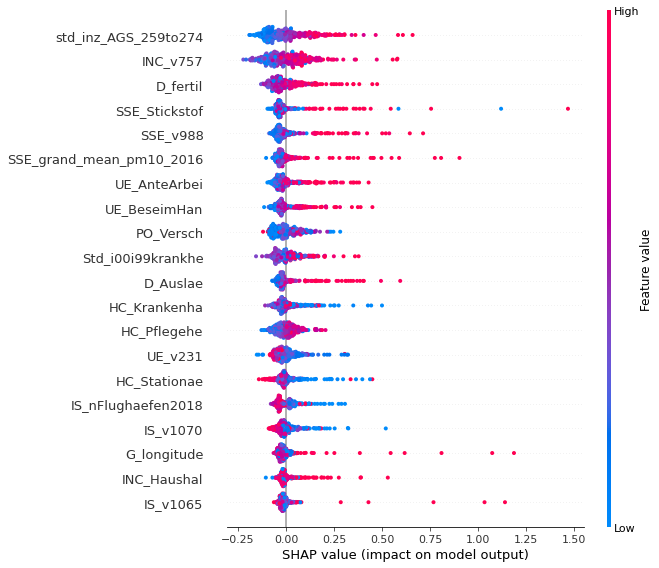

In [17]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [18]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [19]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9979701247137667
Mean R2 of linReg_modesl with top20 features:  0.19211896868903197
Mean RMSE of CatBoost_models on test sets with top20 features:  0.7769535831119396
Mean R2 of CatBoost_models on test sets with top20 features: 0.16303660118141017


# descriptives of top20 features

In [20]:
X[top20feature].describe()

,std_inz_AGS_259to274,SSE_Stickstof,SSE_v988,INC_v757,SSE_grand_mean_pm10_2016,D_fertil,IS_v1070,D_Auslae,IS_v1065,HC_Stationae,UE_BeseimHan,UE_v231,INC_Haushal,G_longitude,HC_Krankenha,Std_i00i99krankhe,PO_Versch,IS_nFlughaefen2018,UE_AnteArbei,HC_Pflegehe
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,26.810415,68.331635,33367.324219,8.945634,14.254108,1.632220,1418.311768,10.034916,21.925186,24.358616,13.988775,15.151626,1591.685791,9.866997,6.353388,350.949554,1682.694702,49.618454,22.971321,97.709465
std,19.821966,27.160891,30681.789062,2.964478,2.204698,0.134031,808.548523,5.149191,15.378860,5.373880,4.891642,3.232546,589.468811,2.026269,3.892253,70.654755,1549.749634,21.984802,4.190942,23.278893
min,0.000000,21.400000,1062.000000,-14.300000,8.902052,1.060000,101.000000,1.900000,0.000000,11.100000,0.000000,9.000000,2.000000,6.083333,0.000000,0.000000,0.000000,6.000000,14.500000,40.700001
25%,13.653437,47.500000,15678.000000,7.700000,12.644478,1.560000,682.000000,6.200000,13.000000,20.400000,10.600000,13.100000,1591.000000,8.216666,3.670000,314.081635,649.700012,33.000000,19.500000,80.400002
50%,22.629042,59.200001,24587.000000,9.000000,14.194455,1.650000,1388.000000,9.200000,21.000000,23.700001,13.900000,14.500000,1764.000000,9.766666,5.450000,348.257904,1167.900024,48.000000,22.700001,96.800003
75%,36.430935,88.199997,39522.000000,10.700000,15.811378,1.720000,2019.000000,13.100000,32.000000,27.500000,16.900000,16.100000,1904.000000,11.416667,8.210000,393.922150,2247.600098,65.000000,25.900000,113.900002
max,173.247955,150.699997,174293.000000,24.700001,21.132412,1.940000,3819.000000,35.000000,79.000000,43.299999,47.700001,28.200001,2904.000000,14.983334,29.590000,538.368652,9908.299805,122.000000,34.700001,184.899994


In [21]:
pd.DataFrame(Y).describe()

,std_leth_AGS_274to289
count,401.000000
mean,0.500069
std,0.887404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.735075
max,4.681872
